# Week 4 assigment: Flask Web App Deployment

# Hourly averaged concentration prediction of CO in mg/m³

The chosen dataset contains 9357 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005, columns from 0 to n-1 represents respectively:

---

**0. Date (DD/MM/YYYY)**

**1. Time (HH.MM.SS)**

**2. True hourly averaged concentration CO in mg/m³ (reference analyzer)**

**3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)**

**4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m³ (reference analyzer)**

**5. True hourly averaged Benzene concentration in microg/m³ (reference analyzer)**

**6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)**

**7. True hourly averaged NOx concentration in ppb (reference analyzer)**

**8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)**

**9. True hourly averaged NO2 concentration in microg/m³ (reference analyzer)**

**10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)**

**11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)**

**12. Temperature in °C**

**13. Relative Humidity (%)**

**14. AH Absolute Humidity**

---

In this proyect, I used linear regression using columns [3,14] to predict the values of the second column given any new information about the input compounds, which is useful to prevent or at least make population aware about carbon monoxide posioning and pollution in/outside the most common carbon monoxide sources such as:

* **Vehicle Emissions**
* **Industrial Activites**
* **Combustion Appliances**
* **Tobacco and Wood Burning**

*Not only it has dreadful consequences for the planet but also it could mean imminent death for humans as it's symptoms can be muscle and consciousness disabling.*

In [32]:
# !pip install -U scikit-learn

In [69]:
import os
import sys

import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import tensorflow.compat.v2.feature_column as fc

---

For this proyect, 70% of the dataset rows will be used as training data and the other 30% as evaluation data, this distribution has proven to be the finest to obtain the lowest error rate possible.

---

In [70]:
# Load dataset
data_frame = pd.read_csv('https://raw.githubusercontent.com/papitaAlgodonCplusplus/LISUM24/main/Week%204/dataset/AirQuality.csv', delimiter=";")

# Shuffle dataset
data_frame = data_frame.sample(frac = 1).reset_index(drop=True)

data_frame = data_frame.drop(columns=data_frame.columns[0])
data_frame = data_frame.drop(columns=data_frame.columns[0])

data_frame = data_frame.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)

data_frame = data_frame.astype(float)
data_frame = data_frame.drop(columns=data_frame.columns[-1])
data_frame = data_frame.drop(columns=data_frame.columns[-1])

data_frame = data_frame.replace(-200, float('nan'))
data_frame = data_frame.dropna()

X_train, X_test, y_train, y_test = train_test_split(data_frame.iloc[:, 1:], data_frame.iloc[:,0], test_size=0.3, random_state=42)

---

In syntax, the first part of the proyect requires reading the information from the csv and store it as a pandas dataframe, making easier common modifications such as deleting, comparing, shuffling, replacing and converting values, after deleting unrequired columns and making all column datatypes as float, the target column or **"label"** is extracted from the **"features"** dataframe and cleaned as well.

---

## **Linear Regression Overview**

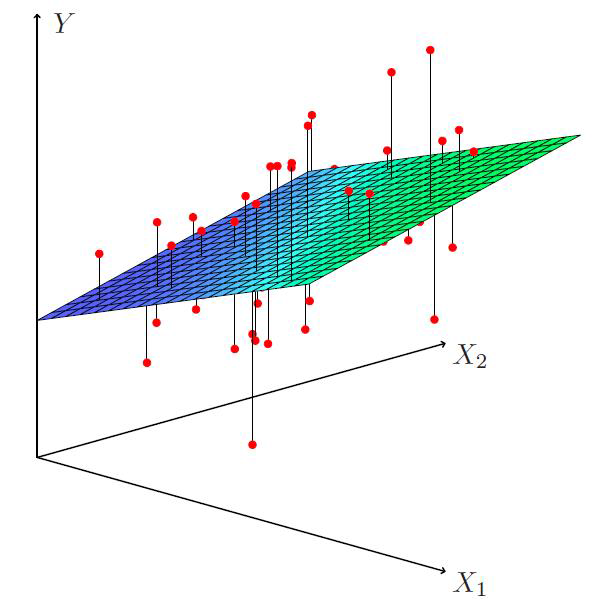

[[Img1 - 3 Dimensional Linear Regression Visualization]](https://medium.com/analytics-vidhya/multiple-linear-regression-an-intuitive-approach-f874f7a6a7f9)

Multivariable linear regression is a statistical modeling technique used to analyze the relationship between multiple independent variables (also known as predictors or features) and a dependent variable (also known as the target variable or response). It extends the concept of simple linear regression, which examines the relationship between a single independent variable and a dependent variable.

In multivariable linear regression, the goal is to fit a linear equation that best predicts the value of the dependent variable based on the values of the independent variables. The equation takes the form:

Y = β0 + β1X1 + β2X2 + ... + βn*Xn + ε

where:

* Y represents the dependent variable
* X1, X2, ..., Xn represent the independent variables
* β0 is the intercept (the value of Y when all independent variables are zero)
* β1, β2, ..., βn are the coefficients that represent the effect of each independent variable on the dependent variable
* ε is the error term, representing the variability that cannot be explained by the independent variables

The coefficients (β1, β2, ..., βn) are estimated using a method called ordinary least squares (OLS), which minimizes the sum of squared differences between the predicted values and the actual values of the dependent variable. The OLS method finds the best-fitting line that minimizes the overall error.

In [64]:
data_frame

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
29,2.6,1379.0,183.0,13.5,1101.0,184.0,818.0,138.0,1710.0,1602.0,17.9,45.9,0.9342
32,1.2,949.0,80.0,3.8,700.0,78.0,1221.0,90.0,1178.0,553.0,13.1,34.4,0.5170
33,3.2,1498.0,445.0,15.7,1171.0,206.0,684.0,114.0,1942.0,1434.0,17.0,54.3,1.0434
72,2.7,1336.0,132.0,11.8,1043.0,256.0,935.0,96.0,1678.0,1192.0,6.5,71.6,0.6945
100,2.5,1402.0,278.0,12.6,1069.0,158.0,733.0,106.0,1793.0,1325.0,19.5,47.5,1.0653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9424,0.7,968.0,51.0,2.6,628.0,56.0,1197.0,66.0,1372.0,737.0,11.3,72.9,0.9738
9425,2.0,1139.0,157.0,8.0,899.0,126.0,921.0,104.0,1514.0,1067.0,14.1,54.4,0.8701
9432,1.5,975.0,97.0,5.6,793.0,119.0,1133.0,97.0,1254.0,637.0,13.9,33.2,0.5222
9459,3.1,1262.0,345.0,14.5,1133.0,157.0,774.0,129.0,1748.0,1033.0,11.3,71.3,0.9514


In [71]:
# Creating the LinearRegressor model
linear_est = LinearRegression()
# Training process
linear_est.fit(X_train, y_train)

LinearRegression()

In [73]:
from sklearn.metrics import mean_squared_error

y_pred = linear_est.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.05878599159200155


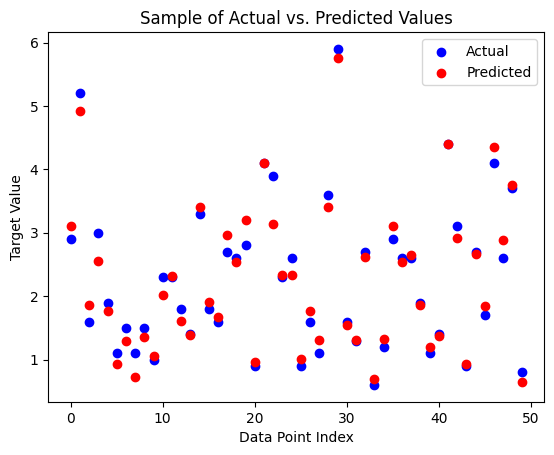

In [74]:
sample_size = 50

plt.scatter(range(sample_size), y_test[:sample_size], color='blue', label='Actual')
plt.scatter(range(sample_size), y_pred[:sample_size], color='red', label='Predicted')
plt.xlabel('Data Point Index')
plt.ylabel('Target Value')
plt.title('Sample of Actual vs. Predicted Values')
plt.legend()
plt.show()

In [77]:
import joblib
joblib.dump(linear_est, '../model/linear_regressor_model.pkl')

['../model/linear_regressor_model.pkl']